In [98]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, chisquare
import scipy.stats as st
import requests
from urllib.parse import urlencode
from io import StringIO
from scipy.stats import mannwhitneyu

## Задача 1
В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. 

Задача заключается в проведении корректного A/B–тестирования.

Цель: проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### Чтение файлов и EDA

In [20]:
# Чтение файлов через API Яндекс диска
def download_file_from_ya_disk(link_to_file):
    BASE_URL = "https://cloud-api.yandex.net/v1/disk/public/resources/download?"

    # Получаем загрузочную ссылку
    final_url = BASE_URL + urlencode(dict(public_key=link_to_file))
    file_download_url_response = requests.get(final_url)
    # Если не смогли достучаться до Яндекса, то выбрасываем ошибку
    if file_download_url_response.status_code != 200:
        raise Exception('Could not get direct file download link :/')
    
    # Загружаем файл и сохраняем его
    file_download_url = file_download_url_response.json()["href"]
    response_with_file = requests.get(file_download_url)

    # Если не смогли достучаться до Яндекса, то выбрасываем ошибку
    if response_with_file.status_code != 200:
        raise Exception('Could not download file :/')
    return response_with_file.content.decode("utf-8")

Файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)

In [21]:
USERS_GROUPS_DATA_LINK = "https://disk.yandex.ru/d/UhyYx41rTt3clQ"
users_groups_data = download_file_from_ya_disk(USERS_GROUPS_DATA_LINK)
groups = pd.read_csv(StringIO(users_groups_data), sep=";")

In [5]:
groups.head(10)

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
5,1803,B
6,1805,B
7,2067,A
8,2078,A
9,2080,B


In [378]:
groups.shape

(74484, 2)

In [379]:
groups.id.nunique()

74484

In [380]:
# объем групп: А (control) = 80%, Б (test) = 20%
groups.grp.value_counts(normalize=True)

B    0.803032
A    0.196968
Name: grp, dtype: float64

In [381]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


Дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

In [22]:
USERS_GROUPS_ADD_DATA_LINK = "https://disk.yandex.ru/d/5Kxrz02m3IBUwQ"
users_groups_add_data = download_file_from_ya_disk(USERS_GROUPS_ADD_DATA_LINK)
groups_add = pd.read_csv(StringIO(users_groups_add_data))

In [7]:
groups_add.head(10)

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B
5,5699132,B
6,5699712,B
7,5700613,B
8,5700771,B
9,5701056,B


In [384]:
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [385]:
groups_add.shape

(92, 2)

In [386]:
# объем групп: А (control) = 24%, Б (test) = 76%
groups_add.grp.value_counts(normalize=True)

B    0.76087
A    0.23913
Name: grp, dtype: float64

In [387]:
groups_add.id.nunique()

92

Файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.

In [23]:
ACTIVE_STUDENTS_DATA_LINK = "https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ"
active_students_data = download_file_from_ya_disk(ACTIVE_STUDENTS_DATA_LINK)
active_studs = pd.read_csv(StringIO(active_students_data))

In [9]:
active_studs.head(10)

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369
5,5481015
6,1353433
7,1394612
8,1170611
9,491277


In [390]:
active_studs.shape

(8341, 1)

In [391]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [392]:
active_studs.nunique()

student_id    8341
dtype: int64

Файл с информацией об оплатах пользователей в дни проведения эксперимента

In [24]:
CHECKS_DATA_LINK = "https://disk.yandex.ru/d/pH1q-VqcxXjsVA"
cheks_data = download_file_from_ya_disk(CHECKS_DATA_LINK)
checks = pd.read_csv(StringIO(cheks_data), sep=';')

In [11]:
checks.head(10)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
5,100645,630.0
6,102534,580.0
7,106837,290.0
8,108270,290.0
9,114366,690.0


In [395]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [396]:
checks.shape

(541, 2)

In [397]:
checks.student_id.nunique()

541

In [398]:
checks.rev.nunique()

39

In [399]:
checks.rev.unique()

array([ 990.    ,  690.    ,  630.    ,  580.    ,  290.    , 1140.    ,
       1900.0001,  199.    ,  398.    , 1830.    , 1900.    , 3260.    ,
       2910.    , 2820.    , 2099.    , 3660.    , 1530.    , 2900.    ,
       1980.    , 1160.    ,  870.    ,  840.    , 2890.    , 1180.    ,
        880.    , 3040.    ,  796.    , 4650.    , 2190.    , 1729.    ,
       1388.    ,  590.    , 2220.    ,  489.    , 1050.    , 1968.    ,
       1339.    ,  597.    , 1039.    ])

### Подготовка данных 
Объединим файлы groups и groups_add

In [25]:
groups_all = pd.concat([groups, groups_add])

In [13]:
groups_all.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [402]:
groups_all.shape

(74576, 2)

In [403]:
74576 - 74484

92

In [404]:
groups_all.id.nunique()

74576

In [405]:
groups_all.grp.value_counts(normalize=True)

B    0.80298
A    0.19702
Name: grp, dtype: float64

Добавим информацию об активности в дни проведения эксперимента

In [26]:
groups_all_and_active = groups_all.merge(active_studs, how='left', left_on='id', right_on='student_id') \
                        .rename(columns={'student_id':'is_active'})

In [11]:
groups_all_and_active.head()

,id,grp,is_active
0,1489,B,NaN
1,1627,A,1627.0
2,1768,B,NaN
3,1783,B,NaN
4,1794,A,NaN


Добавим информацию об оплате

In [27]:
students = groups_all_and_active.merge(checks, how='left', left_on='id', right_on='student_id')

In [13]:
students.head()

,id,grp,is_active,student_id,rev
0,1489,B,NaN,NaN,NaN
1,1627,A,1627.0,1627.0,990.0
2,1768,B,NaN,NaN,NaN
3,1783,B,NaN,NaN,NaN
4,1794,A,NaN,NaN,NaN


In [14]:
students.shape

(74576, 5)

In [28]:
students['is_active'] = students['is_active'].apply(lambda x: 'false' if np.isnan(x) else 'true')
students['has_paid'] = students['rev'].apply(lambda x: 'false' if np.isnan(x) else 'true')
students['rev'] = students['rev'].fillna(0)

In [29]:
students = students.drop(columns=['student_id'])

In [17]:
students.head(10)

,id,grp,is_active,rev,has_paid
0,1489,B,false,0.0,false
1,1627,A,true,990.0,true
2,1768,B,false,0.0,false
3,1783,B,false,0.0,false
4,1794,A,false,0.0,false
5,1803,B,false,0.0,false
6,1805,B,false,0.0,false
7,2067,A,false,0.0,false
8,2078,A,false,0.0,false
9,2080,B,false,0.0,false


In [30]:
# объем групп: А (control) = 20%, Б (test) = 80%
students.grp.value_counts(normalize=True)

B    0.80298
A    0.19702
Name: grp, dtype: float64

### Проверка данных на баги и аномалии

In [31]:
# Пользователи, которые оплатили, но при этом неактивные
bug_data = students.query('has_paid == "true" & is_active == "false"')

In [32]:
bug_data

,id,grp,is_active,rev,has_paid
39,3185,B,false,690.0,true
121,25973,B,false,690.0,true
125,26280,B,false,690.0,true
223,100645,B,false,630.0,true
254,102534,B,false,580.0,true
...,...,...,...,...,...
72452,5291900,B,false,199.0,true
72753,5331842,B,false,290.0,true
73632,5486319,B,false,199.0,true
74049,5562806,B,false,398.0,true


Удалим некорректные записи

In [33]:
students = students.loc[~students.id.isin(bug_data.id)]

In [34]:
students

,id,grp,is_active,rev,has_paid
0,1489,B,false,0.0,false
1,1627,A,true,990.0,true
2,1768,B,false,0.0,false
3,1783,B,false,0.0,false
4,1794,A,false,0.0,false
...,...,...,...,...,...
74571,200247820,B,false,0.0,false
74572,201032527,B,false,0.0,false
74573,201067612,B,false,0.0,false
74574,201067653,B,false,0.0,false


In [16]:
# Проверка
students.query('has_paid == "true" & is_active == "false"')

,id,grp,is_active,rev,has_paid


In [23]:
students.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74427 entries, 0 to 74575
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         74427 non-null  int64  
 1   grp        74427 non-null  object 
 2   is_active  74427 non-null  object 
 3   rev        74427 non-null  float64
 4   has_paid   74427 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 3.4+ MB


In [17]:
# Проверка значений выручки 'rev' (что нет отрицательных и зашкаливающих)
students.describe()

,id,rev
count,7.442700e+04,74427.000000
mean,2.166677e+06,6.285273
std,2.788617e+06,105.144554
min,1.489000e+03,0.000000
25%,9.233500e+05,0.000000
50%,1.671857e+06,0.000000
75%,3.328377e+06,0.000000
max,2.010677e+08,4650.000000


### Распределение данных

In [35]:
pd.crosstab(students['is_active'], students['has_paid'])

has_paid,false,true
is_active,,
false,66086,0
true,7949,392


По таблице сопряженности видно, что оплату производили только активные студенты (те, кто зашел на сайт в период проведения эксперимента) (проверка корректности данных). Всего во время эксперимента более 8000 студентов были активны.

1. Происследуем активных студентов.

In [40]:
students_active = students.query('is_active == "true"')

Распределение дохода с активных студентов:

Text(0.5, 1.0, 'Распределение дохода с активных студентов')

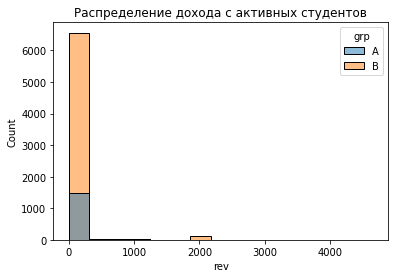

In [41]:
sns.histplot(data=students_active, x='rev', hue='grp') \
    .set_title('Распределение дохода с активных студентов')

По графику видно, что распределение не нормальное, скошенное вправо в сторону 0. 

Определим среднее, медиану и моду дохода c активных студентов в каждой группе:

In [42]:
students_active \
        .groupby('grp', as_index=False) \
        .agg({'rev': ['mean', 'median', pd.Series.mode]})

grp        rev            
            mean median mode
0   A  47.347204    0.0  0.0
1   B  58.058798    0.0  0.0

В данном случае медианное значение более точно показывает "средний" доход с активного платящего пользователя, так как распределения асимметричные и скошенные. Мода показывает тот доход, который принесло наибольшее количество студентов.
Таким образом, в обеих группах "средний" доход с пользователя (медиана) и та сумма, которую заплатили наибольшее число студентов (мода), составляет 0.

2. Исключим тех, кто не оплачивал услуги (has_paid == true), и посмотрим на распределение дохода с активных платящих студентов:

In [43]:
students_active_paid = students_active.query('has_paid == "true"')

Распределение дохода с активных платящих студентов:

Text(0.5, 1.0, 'Распределение дохода с активных платящих студентов')

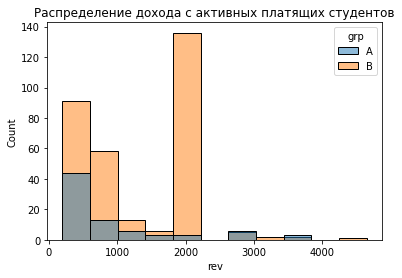

In [44]:
sns.histplot(data=students_active_paid, x='rev', hue='grp') \
    .set_title('Распределение дохода с активных платящих студентов')

По графику видно, что распределения в группах А и B не нормальные, асимметричные и их параметры отличаются.

Определим среднее, медиану и моду дохода c активных платящих студентов в каждой группе:

In [46]:
students_active_paid \
        .groupby('grp', as_index=False) \
        .agg({'rev': ['mean', 'median', pd.Series.mode]})

grp          rev                
              mean  median    mode
0   A   933.589744   585.0   290.0
1   B  1257.878992  1140.0  1900.0

Студенты в группе B, для которых была доступна новая мехника оплаты, в "среднем" принесли больший доход (1140), чем те студенты в группе А, которым был доступен старый способ оплаты (585). Кроме того, подавляющее число студентов в группе А платили по 290, а в группе B - по 1900.

Таким образом, можно сделать предположение, что новая механика оплаты позволяет студентам совершать покупки на бОльшие суммы, то есть новая механика положительно влияет на доход компании.

### Метрики

Так как нас интересуют студенты, которые были активны во время проведения эксперимента, то будем рассматривать только активных студентов.

Посмотрим на следующие метрики и сравним их значения в группах A и B:

1) Revenue - Доход, который принесли студенты, за время проведения эксперимента;

2) Конверсия в оплату CR.

3) ARPU - Средний доход на студента;

4) ARPPU - Средний доход на платящего студента;

5) Медианный ARPPU - Медианный доход на платящего студента;

6) Форма распределения дохода с платящих студентов (не совсем метрика).


#### Зафиксируем уровень значимости для принятия решений до проведения тестов

In [55]:
chosen_alpha = 0.05

#### 1) Revenue

Суммарный доход с активных студентов по группам

Revenue = SUM(rev)

In [47]:
students_active.groupby('grp', as_index=False) \
        .agg({'rev': 'sum'})

,grp,rev
0,A,72820.0000
1,B,394974.0035


Такое сильное различие в метрике Revenue обусловлено разным объемом тестовой и контрольной групп - B (80%), A (20%). Сравнение абсолютного значения суммарного дохода в двух группах некорректно, поэтому перейдем к относительным метрикам.

#### 2) Конверсия в оплату

Рассчитаем конверсию в оплату (относительно активных пользователей) по группам

CR = те, кто оплатил / активные студенты

In [48]:
cr_cont_table = pd.crosstab(students_active['has_paid'], students_active['grp'])

In [49]:
cr_cont_table

grp,A,B
has_paid,,
false,1460,6489
true,78,314


In [50]:
cr_grp_a = cr_cont_table.iloc[1, 0] / cr_cont_table.iloc[:, 0].sum()
print(cr_grp_a)

0.05071521456436931


In [51]:
cr_grp_b = cr_cont_table.iloc[1, 1] / cr_cont_table.iloc[:, 1].sum()
print(cr_grp_b)

0.046156107599588415


Значение конверсии в группе B ниже, чем в группе A. Определим статистическую значимость этих различий с помощью статистического теста.

Используем критерий хи-квадрат для сравнения распределения категориальных случайных величин ('has_paid' - true/false) в двух группах

H0: конверсия в оплату в двух группах одинаковая (то есть доля платящих не зависит от механики оплаты)

H1: конверсия в оплату в двух группах разная (то есть доля платящих зависит от механики оплаты)

In [52]:
chi2, p_value, dof, expected_frequencies = chi2_contingency(cr_cont_table)

In [53]:
print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p_value}")

Chi-Square Statistic: 0.48480826522557896
P-value: 0.48625240457231045


In [56]:
p_value > chosen_alpha

True

p-value =  0.486 > 0.05 -> принимаем H0 о том, что конверсия в оплату в двух группах одинакова

#### Таким образом, в категориальной переменной "группа" (А/Б) в данном эксперименте не удалось обнаружить эффект от внедрения новой механики оплаты - конверсии в двух группах одинаковы. Однако, это не означает, что различий нет вовсе.

#### 3) ARPU

Рассчитаем средний доход на студента

ARPU = SUM(rev) / активные студенты

In [108]:
students_active.groupby('grp', as_index=False) \
            .agg({'rev': ['mean', 'median']})

grp        rev       
            mean median
0   A  47.347204    0.0
1   B  58.058798    0.0

Используем критерий Стьюдента для сравнения средних значений в двух группах

H0: ARPU в двух группах одинаковый (то есть не зависит от механики оплаты)

H1: ARPU в двух группах разный (то есть зависит от механики оплаты)

In [99]:
control_1 = students_active.query('grp == "A"')['rev']

In [100]:
test_1 = students_active.query('grp == "B"')['rev']

Тест Левена на проверку равенства дисперсий в группах

In [61]:
levene_stat, pval = st.levene(control_1, test_1)

In [62]:
print(f"Levene-Statistic: {levene_stat}")
print(f"P-value: {pval}")

Levene-Statistic: 1.501460829433639
P-value: 0.22048133327049665


In [63]:
pval  > chosen_alpha

True

p-value = 0.22 > 0.05 -> принимаем H0 о том, что дисперсии в двух группах не различаются

In [101]:
t_stat_1, p_val_1 = st.ttest_ind(control_1, test_1)

In [102]:
print(f"T-Statistic: {t_stat_1}")
print(f"P-value: {p_val_1}")

T-Statistic: -1.2253411073793445
P-value: 0.22048133326988378


In [103]:
p_val_1 > chosen_alpha

True

p-value =  0.22 > 0.05 -> принимаем H0 о том, что ARPU в двух группах одинаковый

#### Таким образом, в данном эксперименте не удалось обнаружить эффект от внедрения новой механики оплаты - средний доход на студента одинаков в двух группах. Однако, это не означает, что различий нет вовсе.

#### 4) ARPPU

Рассчитаем средний доход на платящего студента

ARPPU = SUM(rev) / активные платящие студенты

In [109]:
students_active_paid.groupby('grp', as_index=False) \
            .agg({'rev': ['mean', 'median']})

grp          rev        
              mean  median
0   A   933.589744   585.0
1   B  1257.878992  1140.0

Используем критерий Стьюдента для сравнения средних значений в двух группах

H0: ARPPU в двух группах одинаковый (то есть не зависит от механики оплаты)

H1: ARPPU в двух группах разный (то есть зависит от механики оплаты)

In [84]:
control_2 = students_active_paid.query('grp == "A"')['rev']

In [85]:
test_2 = students_active_paid.query('grp == "B"')['rev']

Тест на проверку равенства дисперсий в группах

In [75]:
levene_stat_2, pval_2 = st.levene(control_2, test_2)

In [76]:
print(f"Levene-Statistic: {levene_stat_2}")
print(f"P-value: {pval_2}")

Levene-Statistic: 3.075681699981606
P-value: 0.08025675761347022


In [77]:
pval_2  > chosen_alpha

True

p-value = 0.08 > 0.05 -> принимаем H0 о том, что дисперсии в двух группах не различаются

In [78]:
t_stat_2, p_val_2 = st.ttest_ind(control_2, test_2)

In [79]:
print(f"T-Statistic: {t_stat_2}")
print(f"P-value: {p_val_2}")

T-Statistic: -3.1337795050930985
P-value: 0.0018562025265765867


In [80]:
p_val_2 > chosen_alpha

False

p-value =  0.0019 < 0.05 -> отклоняем H0 о том, что ARPPU в двух группах одинаковый и принимаем H1 о том, что ARPPU в двух группах различен.

#### Таким образом, в данном эксперименте удалось обнаружить эффект от внедрения новой механики оплаты - средний доход на платящего студента статистически значимо различается в двух группах.

#### 5) Медианный ARPPU

Как было установлено ранее, распределения дохода в двух группах скошенные и асимметричные, по этой причине  медианные значения обеспечивают более точный результат, чем средние значения.

Применим технологию bootstrap для получения распределения выборочных медиан и применим критерий Стьюдента для сравнения средних выборочных медиан в двух группах.

H0: медианый ARPPU в двух группах одинаковый (то есть не зависит от механики оплаты)

H1: медианый ARPPU в двух группах разный (то есть зависит от механики оплаты)

In [113]:
# Параметры для bootstrap:
# 1000 выборок, по 100 наблюдений в каждой 

np.random.seed(48602)
samples = 1000
draws = 100

In [115]:
# Рассчитываем медиану каждой выборки и создаем новый датафрейм из медиан
control_2_sample = []
for i in range(samples):
    control_2_sample += [control_2.sample(draws, replace=True).median()]

control_2_sample = pd.DataFrame(control_2_sample)

test_2_sample = []
for i in range(samples):
    test_2_sample += [test_2.sample(draws, replace=True).median()]

test_2_sample = pd.DataFrame(test_2_sample)

In [117]:
# Средние значения медиан
print(control_2_sample.mean())
print(test_2_sample.mean())

0    588.557
dtype: float64
0    1324.825
dtype: float64


In [122]:
# Сравним средние значения медиан с помощью t-test
t_stat_2_sample, p_val_2_sample = stats.ttest_ind(control_2_sample, test_2_sample, equal_var=False)

In [123]:
print(f"T-Statistic: {t_stat_2_sample}")
print(f"P-value: {p_val_2_sample}")

T-Statistic: [-63.79659545]
P-value: [0.]


In [125]:
print(p_val_2_sample > chosen_alpha)

[False]


p-value = 0 < 0.05 -> отклоняем H0 о том, что медианное значение дохода в двух группах одинаковые и принимаем H1 о том, что медианный ARPPU в двух группах различен.

#### Таким образом, в данном эксперименте удалось обнаружить эффект от внедрения новой механики оплаты - медианный доход на платящего студента статистически значимо различается в двух группах.

#### 6) Форма распределения дохода с платящих студентов

Сравним теперь не средние значения дохода (ARPPU), а сами распределения с помощью теста Манна-Уитни:

H0: Распределение дохода в двух группах одинаковое (то есть не зависит от механики оплаты)

H1: Распределение дохода в двух группах разное (то есть зависит от механики оплаты)

In [112]:
u_stat_2, p_value_2 = mannwhitneyu(control_2, test_2)
print(u_stat_2, p_value_2)
print(p_value_2 > chosen_alpha)

9001.0 0.0002511393831406922
False


p-value =  0.00025 < 0.05 -> отклоняем H0 о том, что распределения дохода в двух группах одинаковые и принимаем H1 о том, что распределение дохода в двух группах статистически значимо различается.

#### Таким образом, в экспериментах 4-6 обнаружен эффект от внедрения новой механики оплаты и установлены значимые различия по следующим метрикам: 
- Среднее значение дохода на платящего студента (ARPPU);
- Медианное значение дохода на платящего студента (медианный ARPPU).
Кроме того, о значимых различиях говорит и форма распределения дохода с платящих студентов.

### Выводы из экспериментов

В ходе тестов удалось установить значимые различия в метриках ARPPU, медианный ARPPU. Кроме того, о значимых различиях говорит и форма распределения дохода с платящих студентов.

По метрикам конверсии (CR) и ARPU не удалось установить значимых различий в группах. 

Таким образом, эффект от внедрения новой мехники оплаты заключается в том, что новая механика оплаты не увеличила долю платящих студентов (об этом говорит CR), но она позволила этим платящим студентам совершать покупки на более крупные суммы (об этом говорят ARPPU, медианный ARPPU).

Следовательно, новая механика для оплаты увеличивает главную метрику бизнеса - доход (больше ARPPU -> больше Revenue). Ее можно запустить на всех пользователей.

### Рекомендации

Метрики, за которыми обязательно необходимо следить во время A/B эксперимента:
- Целевая метрика: ARPPU, Revenue
- Proxy-метрика: CR в оплату
- Guardrail-метрика: Число успешных транзакций

Следующие изменения в продукте, которые можно протестировать, направлены на увеличение конверсии (доли платящих пользователей). Например, запуск специальных предложений (скидки, акции), введение бонусной системы (накопление бонусов за покупки).

## Задача 2

### 2.1 Очень усердные ученики

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов. NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц

SELECT COUNT(*)
FROM (
    SELECT COUNT(1) as correct_peas
    FROM peas
    WHERE correct = true
    GROUP BY st_id
    HAVING COUNT(1) >= 20 ) AS best_students

### 2.2 Оптимизация воронки
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

ARPU, 
ARPAU, 
CR в покупку, 
СR активного пользователя в покупку, 
CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике.

ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

WITH math_bought AS (
    SELECT st_id AS st_id_math_bought -- id студентов, кто покупал курс Math
    FROM final_project_check
    WHERE subject = 'Math'
),

paying_students AS (
    SELECT st_id, 
        SUM(money) AS money_per_student, -- id студента и сколько денег он заплатил
        CASE WHEN st_id IN (SELECT st_id_math_bought FROM math_bought) THEN 'true' -- true, если оплачивал курс Math
        ELSE 'false'
        END AS bought_math_course
    FROM final_project_check
    GROUP BY st_id
),

student_activity AS (
    SELECT active.st_id, 
        active.peas,
        math_active.math_peas
    FROM
        (SELECT st_id, COUNT(1) AS math_peas -- кол-во горошин по математике
        FROM peas
        WHERE subject = 'Math' AND correct = 'true' 
        GROUP BY st_id
        HAVING COUNT(1) > 1) AS math_active
    RIGHT JOIN 
        (SELECT st_id, COUNT(1) AS peas-- кол-во горошин по любым предметам
        FROM peas
        WHERE correct = 'true' 
        GROUP BY st_id
        HAVING COUNT(1) > 10) AS active ON math_active.st_id = active.st_id
),

student_data AS (
    SELECT studs.st_id,
        studs.test_grp,
        coalesce(paying_students.money_per_student, 0) AS money_per_student,
        coalesce(paying_students.bought_math_course, 'false') AS bought_math_course,
        coalesce(student_activity.peas, 0) AS peas,
        coalesce(student_activity.math_peas, 0) AS math_peas
    FROM studs
    LEFT JOIN paying_students USING(st_id)
    LEFT JOIN student_activity USING(st_id)
)


SELECT test_grp,

    SUM(money_per_student)::float / COUNT(1) AS ARPU,
    
    SUM(money_per_student)::float / (COUNT(1) FILTER (WHERE peas > 10)) AS ARPAU, 
    
    COUNT(1) FILTER (WHERE money_per_student > 0)::float / COUNT(1) AS cr_to_purchase,
    
    COUNT(1) FILTER (WHERE money_per_student > 0 AND peas > 10)::float / COUNT(1) FILTER (WHERE peas > 10) AS cr_from_activity_to_purchase,
    
    COUNT(1) FILTER (WHERE bought_math_course = 'true' AND math_peas > 1)::float / COUNT(1) FILTER (WHERE math_peas > 1) AS cr_from_activity_to_purchase_math
    
FROM student_data
GROUP BY test_grp

## Задача 3

1) Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

2) Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [455]:
# чтение файлов до функции, в функцию передаем датафреймы

In [456]:
def update_groups_and_calculate_metrics(groups, groups_add, active_studs, checks):
    # объединение файлов groups
    groups = pd.concat([groups, groups_add])
    
    # подготовка датафрейма students для анализа
    students = pd.merge(groups, active_studs, how='left', left_on='id', right_on='student_id') \
                    .merge(checks, how='left', on='student_id') \
                    .rename(columns={'student_id': 'is_active'})
    students['is_active'] = students['is_active'].apply(lambda x: 'false' if np.isnan(x) else 'true')
    students['has_paid'] = students['rev'].apply(lambda x: 'false' if np.isnan(x) else 'true')
    students['rev'] = students['rev'].fillna(0)
    
    # все студенты по группам control (a) и test (b)
    all_students_a = students.query('grp == "A"')
    all_students_a_volume = all_students_a.id.count()
    all_students_b = students.query('grp == "B"')
    all_students_b_volume = all_students_b.id.count()
    
    # только активные студенты по группам control (a) и test (b)
    active_students_a = students.query('grp == "A" & is_active == "true"')
    active_students_a_volume = active_students_a.id.count()
    active_students_b = students.query('grp == "B" & is_active == "true"')
    active_students_b_volume = active_students_b.id.count()
    
    # словарь для метрик
    metrics = {}
    
    # конверсия в покупку
    cr_to_purchase_a = all_students_a.query('has_paid == "true"').id.count() / all_students_a_volume
    cr_to_purchase_b = all_students_b.query('has_paid == "true"').id.count() / all_students_b_volume
    crs_to_purchase = [cr_to_purchase_a, cr_to_purchase_b]
    metrics["Конверсия в покупку"] = crs_to_purchase
    
    # конверсия из активности в покупку
    cr_from_action_to_purchase_a = active_students_a.query('has_paid == "true"').id.count() / active_students_a_volume
    cr_from_action_to_purchase_b = active_students_b.query('has_paid == "true"').id.count() / active_students_b_volume
    crs_from_action_to_purchase = [cr_from_action_to_purchase_a, cr_from_action_to_purchase_b]
    metrics["Конверсия из активности в покупку"] = crs_from_action_to_purchase
    
    # ARPU
    arpu_a = all_students_a['rev'].sum() / all_students_a_volume
    arpu_b = all_students_b['rev'].sum() / all_students_b_volume
    arpus = [arpu_a, arpu_b]
    metrics["ARPU"] = arpus
    
    #ARPAU
    arpau_a = active_students_a['rev'].sum() / active_students_a_volume
    arpau_b = active_students_b['rev'].sum() / active_students_b_volume
    arpaus = [arpau_a, arpau_b]
    metrics["ARPAU"] = arpaus
    
    for key, value in metrics.items():
        print(key, 'A / B:', np.round(value, 4))
    
    return metrics

In [457]:
# Проверка работы функции
metrics = update_groups_and_calculate_metrics(groups, groups_add, active_studs, checks)

Конверсия в покупку A / B: [0.0053 0.0052]
Конверсия из активности в покупку A / B: [0.0507 0.0462]
ARPU A / B: [4.9561 6.5958]
ARPAU A / B: [47.3472 58.0588]


In [458]:
print(metrics)

{'Конверсия в покупку': [0.005308650377730892, 0.005243558271963662], 'Конверсия из активности в покупку': [0.05071521456436931, 0.046156107599588415], 'ARPU': [4.956101544953379, 6.595761793831305], 'ARPAU': [47.34720416124838, 58.058798103777754]}


In [459]:
def visualize_metrics(metrics):
    grp = ['A', 'B']
    for key, value in metrics.items():
        plt.figure()
        sns.barplot(x = value, y = grp).set(title=key)
        plt.show()

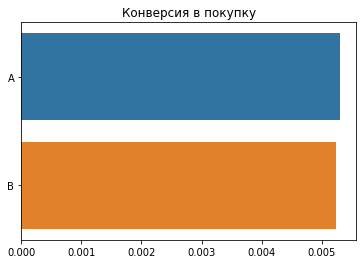

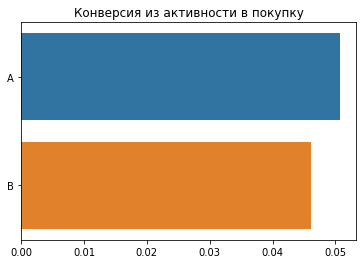

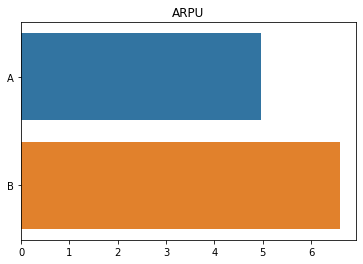

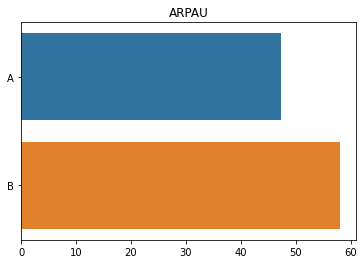

In [460]:
# Проверка работы функции
visualize_metrics(metrics)